In [1]:
%load_ext autoreload
%autoreload 2

# LOCAL
# PROJECT_PATH = '/Users/ivan_zorin/Documents/DEV/code/ntl/'
# DATA_PATH = '/Users/ivan_zorin/Documents/DEV/data/sgcc/data.csv'
# LOG_DIR = '/Users/ivan_zorin/Documents/DEV/runs/debug/trainer'

# ZHORES
PROJECT_PATH = '/trinity/home/ivan.zorin/dev/code/ntl/'
DATA_PATH = '/trinity/home/ivan.zorin/dev/data/sgcc/data.csv'
LOG_DIR = '/trinity/home/ivan.zorin/dev/logs/debug/one-batch/'

In [2]:
import numpy as np 
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk 
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, robust_scale
# from sktime.transformations.series.impute import Imputer

# from functools import partial
from types import SimpleNamespace
import os
from tqdm.auto import tqdm
import warnings
from copy import deepcopy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append(PROJECT_PATH)
from ntl.data import SGCCDataset, data_train_test_split
from ntl.data import FillNA, Scale, Reshape, ToTensor, Cutout, Diff
from ntl.models import AE2dCNN, AE1dCNN
from ntl.trainer import ArgsTrainer
from ntl.utils import fix_seed, get_date, conv2d_shape, convtraspose2d_shape

warnings.filterwarnings('ignore')

In [4]:
fix_seed(42)

Random seed set as 42


In [4]:
fix_seed(42)

transforms = [FillNA('drift'), 
            Cutout(256), 
            Scale('minmax'), 
            Reshape((16, 16)),
            lambda x: x[None],
            ToTensor()
]
normal_data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)
anomal_data = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

train, test = data_train_test_split(normal_data, anomal_data)

train_loader = DataLoader(train, batch_size=256, drop_last=False, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)


Random seed set as 42


### one batch over-fit

In [29]:
good_samples = [13514, 31358, 22438, 37273, 27456, 23631,  5807,  6256, 15156,
       11908, 24435,  4284, 30432, 14438, 34922, 14227, 14265, 19188,
       18604, 28565, 32588, 32074, 17105, 25790, 23358, 30944, 22187,
        4025, 28155, 24512, 15907, 14469, 37924, 14410, 37580,  8650,
       26277,  2456, 16590, 27892, 17740, 11788, 23845,  7156,  8151,
       26515, 10987, 12560,  2673,  6823, 28365,  8282,  8056, 34814,
       21691, 36458, 28601, 21013, 35513, 23407, 24660,  2639, 21320,
          76]

# bad_samples = 


In [115]:
def one_batch_training(one_batch_idxs, i=None, lr=0.001):
    batch_size = 64
    # one_batch_idxs = np.random.randint(0, len(normal_data), batch_size)
    loader = DataLoader(torch.utils.data.Subset(normal_data, one_batch_idxs), batch_size=batch_size)

    model = AE2dCNN(bias=False)
    model_copy = deepcopy(model)
    loss = nn.MSELoss(reduction='none')
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=2, verbose=True)
    logger = SummaryWriter(log_dir=os.path.join(LOG_DIR, get_date())) 

    config = SimpleNamespace(**{
        'debug': True,
        'n_debug_batches': 1,
        'log_step': 5,
        'n_epochs': 100,
        'split_val_losses': True,
        'LOG_DIR': LOG_DIR
    })

    trainer = ArgsTrainer(
        train_loader=loader,
        val_loader=loader,
        model=model,
        loss=loss,
        optim=optim,
        scheduler=scheduler,
        config=config,
        logger=logger
    )

    losses = []
    for epoch in tqdm(range(100)):
        train_loss = trainer.train_step(epoch)
        trainer.logger.add_scalars('loss', {'train': train_loss}, epoch)
        losses.append(train_loss.item())
        
    plt.figure()
    plt.plot(losses)
    plt.title(i)
    plt.show()
    print('=' * 60)
    
    return model_copy

In [61]:
batch_size = 64
idxs = np.arange(len(normal_data) - 45).reshape(batch_size, -1).T

In [ ]:
warnings.filterwarnings('ignore')
for i, idx in enumerate(idxs):
    one_batch_training(idx, i)

  0%|          | 0/100 [00:00<?, ?it/s]

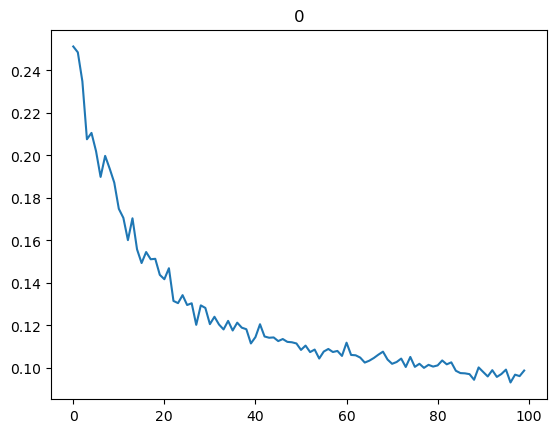

  0%|          | 0/100 [00:00<?, ?it/s]

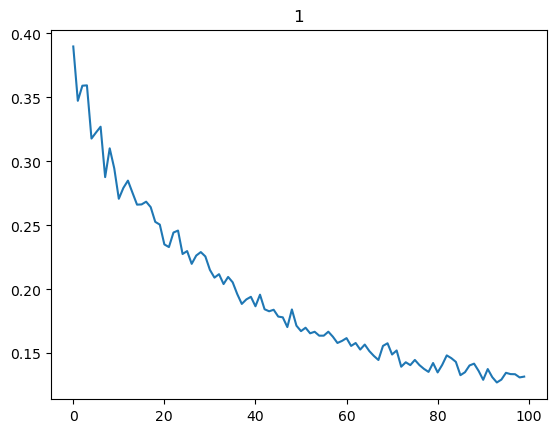

  0%|          | 0/100 [00:00<?, ?it/s]

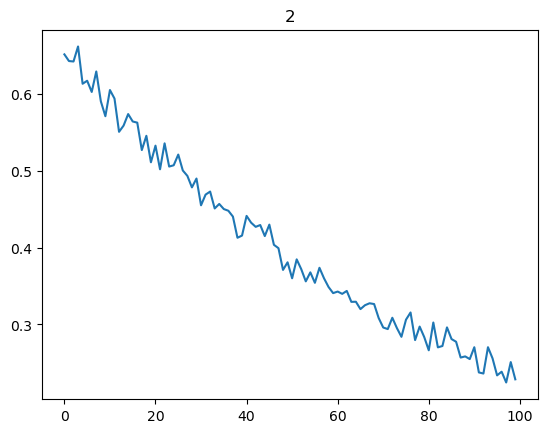

  0%|          | 0/100 [00:00<?, ?it/s]

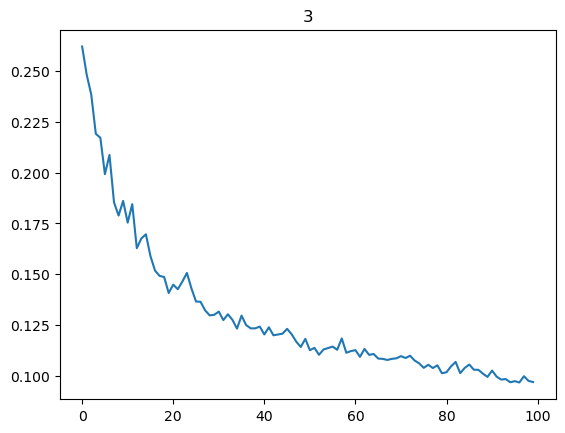

  0%|          | 0/100 [00:00<?, ?it/s]

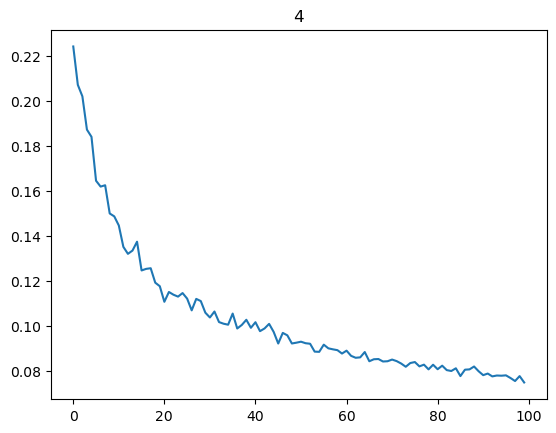

In [117]:
models = []
for i in range(5):
    model = one_batch_training(idxs[0, :], i, lr=0.0001)
    models.append(model)
    print('=' * 10)

In [106]:
channels = [1, 4, 16, 32, 64]
hin = 16
hins = [hin]
for channel in channels:
    hin = conv2d_shape(hin, pad=0, dilation=1, kernel=3, stride=1)
    hins.append(int(hin))

hins = [[h, h] for h in hins]
    

In [ ]:
for sample in train:
    x = sample[1]
    emb, x_hat = trainer.model(x.to(trainer.device))

    x = x.flatten().numpy().squeeze()
    x_hat = x_hat.detach().flatten().cpu().numpy().squeeze()
    plt.figure()
    plt.plot(x, 'b--')
    plt.plot(x_hat, 'r')
    plt.show()

In [ ]:
for i, sample in enumerate(train):
    x = sample[1].flatten().numpy().squeeze()
    plt.figure()
    plt.plot(np.diff(x, n=1))
    plt.title(i)
    plt.show()
    

#### check average values of normalized inputs

In [ ]:
transforms = [FillNA('drift'), 
            Cutout(256), 
            Scale('minmax'), 
            # Reshape((16, 16)),
            # lambda x: x[None],
            # ToTensor()
]
normal_data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)
anomal_data = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

train, test = data_train_test_split(normal_data, anomal_data)

In [ ]:
max_values, min_values, mean_values, median_values = [], [], [], []
for sample in tqdm(train):
    x = sample[1]
    max_values.append(x.max())
    min_values.append(x.min())
    mean_values.append(x.mean())
    median_values.append(np.median(x))
    

In [ ]:
def plot_hist(data, title=''):
    plt.figure()
    plt.hist(data, density=True)
    plt.title(title)
    plt.show()
    


In [ ]:
# plot_hist(max_values, 'max_values')
# plot_hist(min_values, 'min_values')
plot_hist(mean_values, 'mean_values')
# plot_hist(median_values, 'median_values')


In [ ]:
idx = 10
sample = train[idx][1]
print(sample.mean())

plt.figure()
plt.plot(sample)
plt.show()


### Transformations 

In [ ]:
transforms = [
    FillNA('drift'), 
    # Cutout(256), 
    # Scale('minmax'), 
    # Reshape((16, 16)),
    # lambda x: x[None],
    # ToTensor()
]
data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

In [ ]:
diff_tr = Diff(1)
scale_tr = Scale('minmax')

In [ ]:
idx = np.random.randint(0, len(data))
x = data[idx][1]

In [ ]:
x1 = diff_tr(scale_tr(x))
x2 = scale_tr(diff_tr(x))

In [ ]:
plt.figure()
plt.plot(x1, 'b', label='x1')
plt.plot(x2, 'r', label='x2')
plt.show()


### VAE

In [ ]:
class VAE2dCNN(BaseAE):
    def __init__(self, bias=False):
        super().__init__()
        self.bias = bias
        channels = [1, 4, 16, 32, 64]
        layers = []
        for i in range(len(channels) - 1):
            layers += [
                nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], stride=1, kernel_size=3, padding=0, bias=bias),
                nn.BatchNorm2d(num_features=channels[i+1]),
                nn.Dropout(0.15),
                nn.ReLU(),

            ]
            
        self.encoder = nn.Sequential(*layers)
        
        channels.reverse()

        layers = []
        for i in range(len(channels) - 1):

            layers += [
                nn.ConvTranspose2d(in_channels=channels[i], out_channels=channels[i+1], stride=1, kernel_size=3, padding=0, bias=bias),
                nn.BatchNorm2d(num_features=channels[i+1]),
                nn.Dropout(0.15),
                nn.ReLU()
            ]
            
        self.decoder = nn.Sequential(*layers)

In [8]:
from torch import tensor as Tensor
from typing import Callable, List

In [ ]:
class VanillaVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    
    def forward(self, x, x_hat):
        pass

### Model Analysis

In [5]:
model_ckpt_path = '/beegfs/home/ivan.zorin/dev/logs/CNNAE_BN_noBias/23_09_27_12_25/model_ckpt_end.pt'
model = torch.load(model_ckpt_path)

In [6]:
device = 'cuda'


In [7]:
def evaluate(model, loader, loss_fn = F.mse_loss, device='cuda'):
    embeddings = []
    losses = []
    labels = []
    
    t = tqdm(loader)
    for i, batch in enumerate(t):
        with torch.no_grad():
            label, x, _ = batch 
            x = x.to(device)
            z, x_hat = model(x)
            loss = loss_fn(x, x_hat, reduction='none').squeeze().mean(dim=(1,2))
            
            losses.append(loss.detach().cpu().numpy())
            embeddings.append(z.detach().cpu().numpy())
            labels.append(label.numpy())
            
    losses = np.concatenate(losses)
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return losses, embeddings, labels

In [8]:
train_losses, train_embeddings, train_labels = evaluate(model, train_loader)

  0%|          | 0/138 [00:00<?, ?it/s]

In [9]:
test_losses, test_embeddings, test_labels = evaluate(model, test_loader)


  0%|          | 0/28 [00:00<?, ?it/s]

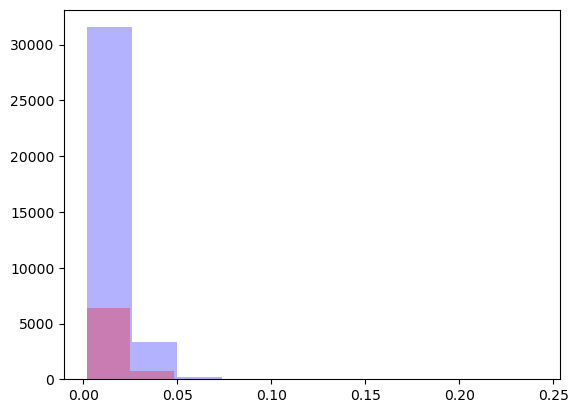

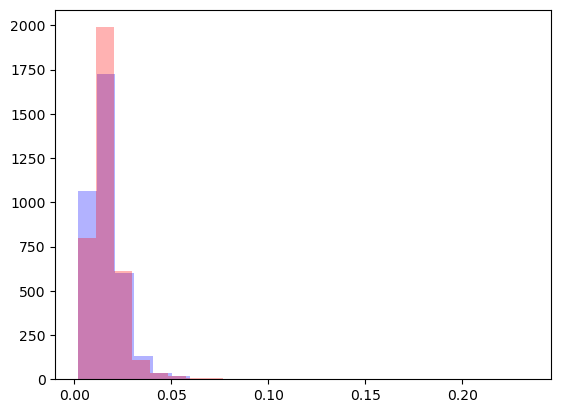

In [52]:
plt.figure()
plt.hist(train_losses, color='b', alpha=0.3)
plt.hist(test_losses, color='r', alpha=0.3)
plt.show()

plt.figure()
plt.hist(test_losses[test_labels == 0], 24, color='b', alpha=0.3)
plt.hist(test_losses[test_labels == 1], 24, color='r', alpha=0.3)
plt.show()


In [22]:

def compute_tsne(train, test, train_labels, test_labels):
    lengths = (train.shape[0], test.shape[0] // 2, test.shape[0] // 2)
    labels = np.concatenate([train_labels, test_labels])
    data = np.concatenate([train, test])

    tsne = TSNE(2)
    data_tsne = tsne.fit_transform(data)

    return data_tsne, labels, lengths

In [25]:
def plot_embeddings(data, labels, lengths, title=''):
    fig = plt.figure()
    train_N, test_normal_N, test_anomal_N = lengths
    # train
    plt.scatter(data[:train_N, 0], data[:train_N, 1], color='b', marker='.', label='train normal')
    # test normal
    plt.scatter(data[train_N:train_N + test_normal_N, 0], data[train_N:train_N + test_normal_N, 1], color='g', marker='1', label='test normal')
    # test anomal
    plt.scatter(data[train_N + test_normal_N:, 0], data[train_N + test_normal_N:, 1], color='r', marker='x', label='test anomal', alpha=0.2)
    plt.legend()
    plt.title(title)
    plt.show()
    return fig

In [11]:
lengths = (train_embeddings.shape[0], test_embeddings.shape[0] // 2, test_embeddings.shape[0] // 2)
labels = np.concatenate([train_labels, test_labels])
data = np.concatenate([train_embeddings, test_embeddings])


tsne = TSNE(2)
data_tsne = tsne.fit_transform(data)

In [23]:
data_tsne, labels, lengths = compute_tsne(train_embeddings, test_embeddings, train_labels, test_labels)

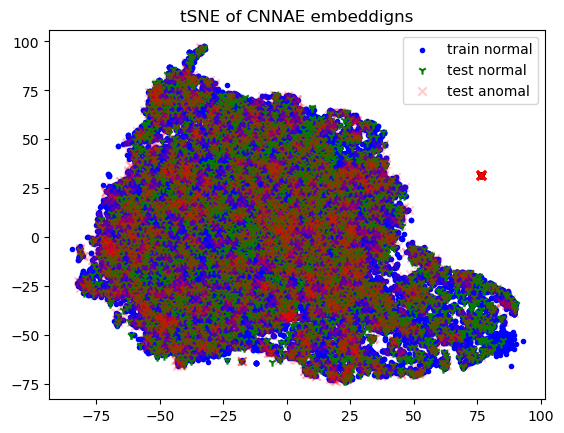

In [26]:
_ = plot_embeddings(data_tsne, labels, lengths, 'tSNE of CNNAE embeddigns')

In [27]:
def plot_res(labels, scores, n_components=''):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)
    
    t = np.linspace(0, 1, fpr.shape[0])
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot(t, t, 'r--', alpha=0.4)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC-AUC of GMM({n_components})')
    plt.text(x=0.7, y=0, s=f'AUC: {np.round(auc, 4)}', fontdict={'size': 15})
    plt.show()
        
        
def fit_and_test_gmm(train, test, labels, **gmm_kwargs):
    gmm = GaussianMixture(**gmm_kwargs)
    gmm.fit(train)
    test_scores = gmm.score_samples(test)
    plot_res(labels, test_scores, n_components=gmm_kwargs['n_components'])

GMM on losses


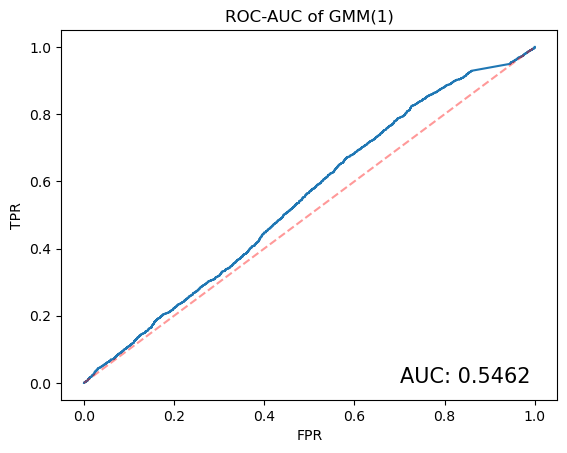

In [36]:
print('GMM on losses')
fit_and_test_gmm(train_losses.reshape(-1, 1), test_losses.reshape(-1, 1), test_labels, n_components=1)

GMM on embeddings


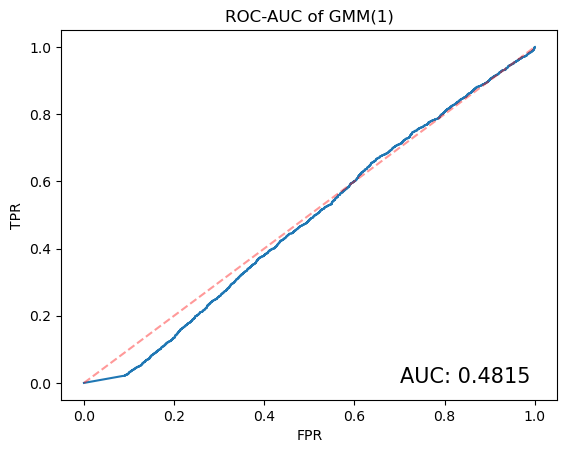

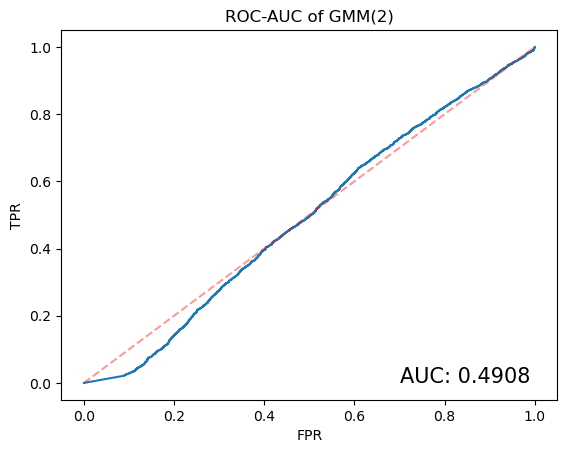

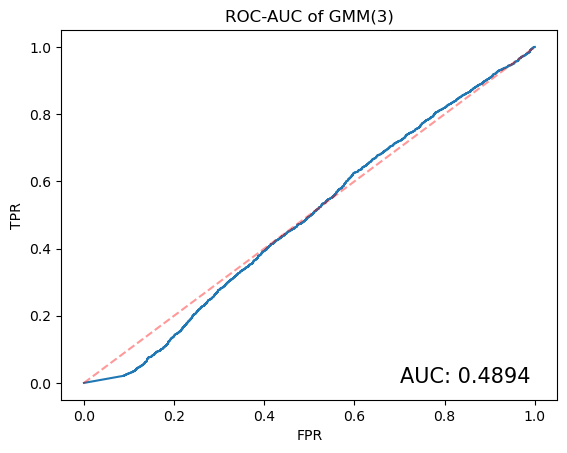

In [37]:
print('GMM on embeddings')
for n in range(1, 6):
    fit_and_test_gmm(train_embeddings, test_embeddings, test_labels, n_components=n)

### AE with conv1d

In [15]:
transforms = [FillNA('drift'), 
            # Cutout(256), 
            Scale('minmax'), 
            # Reshape((16, 16)),
            # lambda x: x[None],
            ToTensor()
]
data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

loader = DataLoader(data, batch_size=256, drop_last=False, shuffle=True)


In [5]:
device = 'cuda'

In [11]:
_, x, _ = next(iter(loader))
x = x.transpose(1,2)

In [67]:
def call_layers(input, layers):
    for layer in layers:
        input = layer(input)
        print(input.shape)
    
    return input

In [83]:
conv1d_layers = []
conv1d_dims = [1, 4, 8, 16, 32]

for i in range(len(conv1d_dims) - 1):
    conv1d_layers += [
        nn.Conv1d(in_channels=conv1d_dims[i], out_channels=conv1d_dims[i+1],kernel_size=7, stride=1, dilation=3, bias=False)
    ]
    
conv1d_strided = []
conv1d_dims_strided = [32, 64, 128, 256, 512]
kernels = [3, 5, 7, 5]
for i in range(len(conv1d_dims_strided) - 1):
    conv1d_strided += [
        nn.Conv1d(in_channels=conv1d_dims_strided[i], out_channels=conv1d_dims_strided[i+1], kernel_size=kernels[i], stride=2, dilation=1, bias=False)
        
    ]


linear_flatten = [nn.Linear(in_features=11, out_features=1, bias=True), nn.Flatten(1,2)]
linear_layers = []
linear_dims = [512, 512, 512]
for i in range(len(linear_dims) - 1):
    linear_layers += [
        nn.Linear(in_features=linear_dims[i], out_features=linear_dims[i+1], bias=True)
    ]

linear_unflatten = [nn.Unflatten(1, (512, 1)),
                  nn.Linear(1, 11)]

reverse_conv1d_strided = []
kernels.reverse()
conv1d_dims_strided.reverse()
conv1d_dims.reverse()
output_paddings = [0, 1, 0, 1]
for i in range(len(conv1d_dims_strided) - 1):
    reverse_conv1d_strided += [
        nn.ConvTranspose1d(in_channels=conv1d_dims_strided[i], out_channels=conv1d_dims_strided[i+1], kernel_size=kernels[i], stride=2, output_padding=output_paddings[i])
    ]
    
reverse_conv1d = []
for i in range(len(conv1d_dims) - 1):
    reverse_conv1d += [
        nn.ConvTranspose1d(in_channels=conv1d_dims[i], out_channels=conv1d_dims[i+1], kernel_size=7, dilation=3)
    ]

# layers = conv1d_layers + conv1d_strided + linear_flatten + linear_layers + linear_unflatten + reverse_conv1d_strided + reverse_conv1d


In [84]:
_, x, _ = next(iter(loader))
x = x.transpose(1,2)
print(x.shape)

print('conv1d')
x = call_layers(x, conv1d_layers)
print('=' * 10)

print('conv1d strided')
x = call_layers(x, conv1d_strided)
print('=' * 10)

print('linear + flatten')
x = call_layers(x, linear_flatten)
print('=' * 10)

print('linear')
x = call_layers(x, linear_layers)
print('=' * 10)

print('linear + unflaten')
x = call_layers(x, linear_unflatten)
print('=' * 10)

print('reverse conv1d strided')
x = call_layers(x, reverse_conv1d_strided)
print('=' * 10)

print('reverse conv1d')
x = call_layers(x, reverse_conv1d)
print('=' * 10)



torch.Size([256, 1, 304])
conv1d
torch.Size([256, 4, 286])
torch.Size([256, 8, 268])
torch.Size([256, 16, 250])
torch.Size([256, 32, 232])
conv1d strided
torch.Size([256, 64, 115])
torch.Size([256, 128, 56])
torch.Size([256, 256, 25])
torch.Size([256, 512, 11])
linear + flatten
torch.Size([256, 512, 1])
torch.Size([256, 512])
linear
torch.Size([256, 512])
torch.Size([256, 512])
linear + unflaten
torch.Size([256, 512, 1])
torch.Size([256, 512, 11])
reverse conv1d strided
torch.Size([256, 256, 25])
torch.Size([256, 128, 56])
torch.Size([256, 64, 115])
torch.Size([256, 32, 232])
reverse conv1d
torch.Size([256, 16, 250])
torch.Size([256, 8, 268])
torch.Size([256, 4, 286])
torch.Size([256, 1, 304])


In [86]:
from ntl.models import AE1dCNN

In [26]:
model = AE1dCNN()

In [33]:
_, x, _ = next(iter(loader))
x = x.transpose(1,2)
x.shape

torch.Size([256, 1, 304])

In [34]:
emb, x_hat = model(x)
x_hat.shape

torch.Size([256, 1, 304])

In [35]:
x.shape == x_hat.shape

True

In [19]:
x.shape, x_hat.shape

(torch.Size([256, 1, 304]), torch.Size([256, 304, 1]))

### Notes

* normalize data to 0,1 scale | check
* fill nans | check
* cut-out some piece | check
* reshape into matrix (7x52, square, other?) | check
* use this matrix as input into AE | check


Two ways of transformation 
The first one 
1. cut-out some piece
2. fill na
3. scale 
4. reshape

The second one 
1. fill na
2. scale
3. cut-out some piece
5. reshape

**#TODO**

* add x and x_hat plots | check
* split val_loss into two -- val_normal_loss, val_anomal_loss | check
* add GMM on scores
